### Experiment with methods:

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

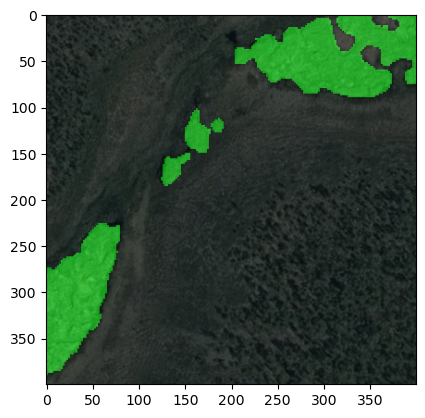

In [19]:
from rasterio.features import shapes
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image

filename = "753_67_2550_2014_crop_61"
image = Image.open(f"/Users/nadja/Documents/1. Project/Thesis/Permafrost-Segmentation/Verified_GT/jpg_rgb/{filename}.jpg")
pseudomask = Image.open(f"/Users/nadja/Documents/1. Project/Thesis/Permafrost-Segmentation/Verified_GT/png_GT/{filename}.png")
pseudomask = np.squeeze(pseudomask)
pseudomask = np.array(Image.fromarray(pseudomask).resize((400, 400), Image.NEAREST))  # Upsample to 400x400

pseudomask_overlay = np.array(image) * 0.5 + np.expand_dims(pseudomask, axis=2) * np.array([4, 250, 7]) * 0.5
pseudomask_overlay = pseudomask_overlay.astype(np.uint8)
plt.imshow(pseudomask_overlay)
plt.set_title("Pseudomask", size= 20)

In [22]:
!pip install shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.1 MB/s eta 0:00:00


In [23]:
from shapely import Polygon


def mask_to_polygons_rasterio(binary_mask):
    # Get polygon shapes with their values
    results = (
        {'properties': {'value': value}, 'geometry': geometry}
        for geometry, value in shapes(binary_mask.astype(np.uint8))
    )
    
    # Convert to Shapely polygons
    polygons = [
        Polygon(shape['geometry']['coordinates'][0])
        for shape in results
        if shape['properties']['value'] == 1  # Assuming 1 is your mask value
    ]
    
    return polygons

polygons = mask_to_polygons_rasterio(pseudomask)

In [29]:
polygons[1].bounds

(178.0, 112.0, 192.0, 128.0)

In [36]:
print(polygons[1].exterior.xy)


(array('d', [186.0, 186.0, 185.0, 182.0, 182.0, 181.0, 180.0, 180.0, 179.0, 178.0, 178.0, 180.0, 180.0, 182.0, 182.0, 190.0, 190.0, 191.0, 192.0, 192.0, 190.0, 190.0, 188.0, 188.0, 186.0]), array('d', [112.0, 114.0, 114.0, 114.0, 116.0, 116.0, 116.0, 118.0, 118.0, 118.0, 122.0, 122.0, 126.0, 126.0, 128.0, 128.0, 124.0, 124.0, 124.0, 116.0, 116.0, 114.0, 114.0, 112.0, 112.0]))


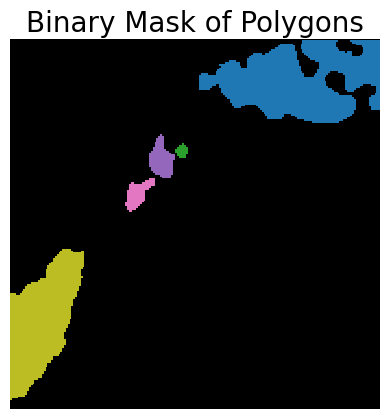

In [25]:
import matplotlib.pyplot as plt

# Create a binary mask from the polygons
binary_mask = np.zeros((400, 400), dtype=np.uint8)
for polygon in polygons:
    # Create a mask for each polygon
    x, y = polygon.exterior.xy
    plt.fill(x, y, 1)

plt.imshow(binary_mask, cmap='gray')
plt.title("Binary Mask of Polygons", size=20)
plt.axis('off')  # Hide axes
plt.show()

In [31]:
import json

filename = "753_67_2550_2014_crop_61"
metadata_path = f"/Volumes/USB/Orig_200m_TIFS/tif_metadata/{filename}_metadata.json"

# Read metadata from JSON file
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

In [35]:
metadata['bounds']

{'left': 675200.0, 'bottom': 7533500.0, 'right': 675400.0, 'top': 7533700.0}

### Generating shapefile

Args:
- Model: Trained Segformer
- JPG Directory: Directory containing images to be segmented
- Metadata Directory: Directory with metadata for each image to be segmented

Output: 
- Shapefile: Derived from GeoDataFrame

In [ ]:
import torch
from torch import nn
from torchmetrics.functional import jaccard_index
from torchmetrics.functional.classification import multiclass_accuracy
from tqdm import tqdm
from transformers import get_linear_schedule_with_warmup
import torch.nn.functional as F
from transformers import SegformerForSemanticSegmentation

from transformers import SegformerImageProcessor
import pandas as pd 
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
import os
from PIL import Image
import numpy as np
import wandb

# adapted from https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Fine_tune_SegFormer_on_custom_dataset.ipynb
class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegformerImageProcessor): image processor to prepare images + segmentation maps.
        """
        self.root_dir = root_dir
        self.image_processor = SegformerImageProcessor(
            image_mean = [74.90, 85.26, 80.06], # use mean calculated over our dataset
            image_std = [15.05, 13.88, 12.01], # use std calculated over our dataset
            do_reduce_labels=False
            )

        self.img_dir = os.path.join(self.root_dir, "images")
        self.ann_dir = os.path.join(self.root_dir, "masks")
        
        # Get all image filenames without extension
        dataframe = pd.read_csv(
            f"{root_dir}/orig_palsa_labels.csv", 
            names=['filename', 'palsa'], 
            header=0
            )
        
        dataframe = dataframe.loc[dataframe['palsa']>0]
        dataframe = dataframe[~dataframe['filename'].str.endswith('aug')]
        checked_names = list(dataframe['filename'])
        self.filenames = [os.path.splitext(f)[0] for f in os.listdir(self.img_dir) if f[:-4] in checked_names]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img_path = os.path.join(self.img_dir, f"{img_name}.jpg")
        ann_path = os.path.join(self.ann_dir, f"{img_name}.png")

        image = Image.open(img_path)
        segmentation_map = Image.open(ann_path)

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.image_processor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs, img_name

In [ ]:
import json
import geopandas as gpd
import os
from rasterio.features import shapes
import numpy as np 
from shapely import Polygon

class MakeShapefile():
    """
    Args:
        - model (trained Segformer)
        - filenames (of jpgs to be segmented)
        - img_dir (where jpgs are)
        - metadata_dir (where metadata is saved)
        - output_path (where to save shapefile)
    
    Returns:
        - Shapefile with all polygons
    """

    def __init__(self, model, loaders, metadata_dir, output_path):
        self.model = model
        self.loaders = loaders
        self.metadata_dir = metadata_dir
        self.output_path = output_path
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.GeoDF = gpd.GeoDataFrame(columns=['geometry'])

    def main(self):

        for loader in self.loaders:

            for batch_id, [batch, img_name] in enumerate(loader):
                # get the inputs;
                pixel_values = batch["pixel_values"].to(self.device)
                labels = batch["labels"].to(self.device)

                # forward pass
                outputs = self.model(pixel_values=pixel_values, labels=labels)
                logits = outputs.logits
                upsampled_logits = F.interpolate(
                    logits.unsqueeze(1).float(), 
                    size=[logits.shape[1],labels.shape[-2],labels.shape[-1]], 
                    mode="nearest")

                # Convert logits to binary segmentation mask
                predicted = torch.argmax(logits, dim=1)  # Shape: (batch_size, 128, 128)
                
                # Upsample the predicted mask to match the label size
                upsampled_predicted = F.interpolate(
                    predicted.unsqueeze(1).float(), 
                    size=400, 
                    mode="nearest"
                )

                # obtain polygons from mask
                polygons = self.generate_polygons(upsampled_predicted.squeeze().cpu().numpy())

                # save polygons in DF with correct metadata
                self.save_polygons(polygons, img_name)

                print(f"{4*batch_id} imgs created")

            print("FIRST LOADER DONE!")

        # save the geodataframe with all polygons as a shapefile
        self.GeoDF.to_file(self.output_path)

    def generate_polygons(self, binary_mask):

        # Get polygon shapes with their values
        results = (
            {'properties': {'value': value}, 'geometry': geometry}
            for geometry, value in shapes(binary_mask.astype(np.uint8))
        )
        
        # Convert to Shapely polygons
        polygons = [
            Polygon(shape['geometry']['coordinates'][0])
            for shape in results
            if shape['properties']['value'] == 1  # Assuming 1 is your mask value
        ]

        return polygons

    def save_polygons(self, polygons, img_name):

        # generate metadata path
        metadata_path = os.path.join(self.metadata_dir, f"{img_name[0]}_metadata.json")

        # Read metadata from JSON file
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        
        # Get the bounds from the metadata
        bounds = metadata['bounds']
        min_x, min_y, max_x, max_y = bounds['left'], bounds['bottom'], bounds['right'], bounds['top']

        # Calculate the scale factors
        scale_x = (max_x - min_x) / 400
        scale_y = (max_y - min_y) / 400

        # Convert each polygon to absolute coordinates and add to GeoDataFrame
        for polygon in polygons:
            # Get the exterior coordinates of the polygon
            x, y = polygon.exterior.xy
            
            # Convert relative coordinates to absolute coordinates
            absolute_x = [min_x + (xi * scale_x) for xi in x]
            absolute_y = [min_y + (yi * scale_y) for yi in y]
            
            # Create a new polygon with absolute coordinates
            absolute_polygon = Polygon(zip(absolute_x, absolute_y))
            
            # Append to GeoDataFrame
            new_gdf = gpd.GeoDataFrame({'geometry': [absolute_polygon]})
            self.GeoDF = gpd.GeoDataFrame(pd.concat([self.GeoDF, new_gdf], ignore_index=True))

In [ ]:
import numpy as np
import torch
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import wandb
import rasterio
from torch.utils.data import DataLoader

# Specify the artifact path
model_name = "nvidia/segformer-b5-finetuned-ade-640-640"
artifact_name = 'finetuned_segformer:v45'
artifact_path = f'nadjaflechner/Finetune_segformer/{artifact_name}'

# Initialize wandb API
api = wandb.Api()

# Download the artifact
artifact = api.artifact(artifact_path)
artifact_dir = artifact.download()

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegformerForSemanticSegmentation.from_pretrained(
    model_name,
    num_labels=2,
    ignore_mismatched_sizes=True
).to(device)

# Load the state dict
state_dict = torch.load(f"{artifact_dir}/best_model.pth", map_location=device)
model.load_state_dict(state_dict)
model.eval()

# Create the train/test datasets
train_dir = "/root/Thresholded_CAM_1.6/TRAIN"
train_set = SemanticSegmentationDataset(train_dir)
train_loader = DataLoader(train_set, batch_size = 1)

test_dir = "/root/Thresholded_CAM_1.6/TEST"
test_set = SemanticSegmentationDataset(test_dir)
test_loader = DataLoader(test_set, batch_size = 1)

metadata_path = "/root/tif_metadata"
output_path = "/root/thresh_palsa_predictions.shp"

# initiate generation object
shapefilemaker = MakeShapefile(
    model, [train_loader, test_loader], metadata_path, output_path
    )

shapefilemaker.main()